In [76]:
# general imports
import numpy as np
import random
import pandas as pd
from math import ceil
from scipy import linalg
#import csaps as cs
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error as mse, r2_score
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import GridSearchCV,train_test_split as tts
from sklearn.datasets import make_spd_matrix
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import pyplot
import pygam

In this project you will compare the performance of the Geberalized Additive Model with the Nadaraya-Watson regressor.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The output data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

You will generate 1-D (input) data and simulate a noised output of a rapidly oscillating function on the interval [0,20]; you will fit both regressors on a train set and measure their error on a test set.

In [3]:
# generate the data

x = np.random.uniform(0,20,100)
y = np.cos(x**2/20)
y_noise = np.cos(x**2/20) + np.random.uniform(0,1,100)

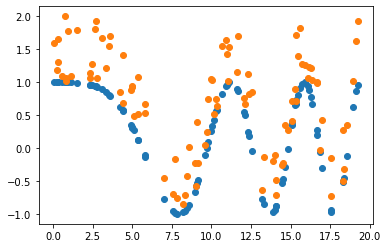

In [5]:
plt.scatter(x,y)
plt.scatter(x,y_noise)

plt.show()

In [6]:
xtrain, xtest, ytrain, ytest = tts(x,y_noise,test_size=.3)

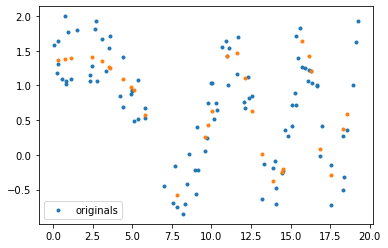

In [23]:
model = get_natural_cubic_spline_model(xtrain, ytrain, minval=min(xtrain),  maxval=max(xtrain), n_knots=16)

gam_y_est = model.predict(xtest)


plt.scatter(x, y_noise, marker='.', label='originals')
plt.scatter(xtest, gam_y_est, marker='.')
plt.legend(); 
plt.show()


In [24]:
r2_score(ytest,gam_y_est)

0.8290690676624839

In [25]:
from nadaraya_watson import NadarayaWatson, NadarayaWatsonCV

In [26]:
param_grid=[dict(kernel=['polynomial'], degree=np.arange(1, 5)),dict(kernel=['rbf'], gamma=np.logspace(-5, 5, 100))]

# use the sklearn gridsearch
nw_gs = GridSearchCV(NadarayaWatson(), cv=10, param_grid=param_grid)
nw_gs.fit(xtrain.reshape(-1,1),ytrain)
nw_y_est = nw_gs.predict(xtest)

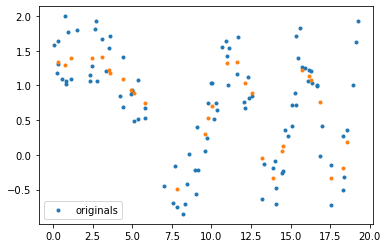

In [27]:
plt.scatter(x, y_noise, marker='.', label='originals')
plt.scatter(xtest, nw_y_est, marker='.')
plt.legend(); 
plt.show()

In [28]:
r2_score(ytest,nw_y_est)

0.7815173288347291

Show a plot comparing the two reconstructions of the gound truth function.


In [46]:
gam = pd.DataFrame({'x':xtest, 'y':gam_y_est}).sort_values(by='x')

def f(i):
   return np.cos(i**2/20)

i = np.arange(0,20,.1)

x1, y1 = zip(*sorted(zip(xtest, nw_y_est)))

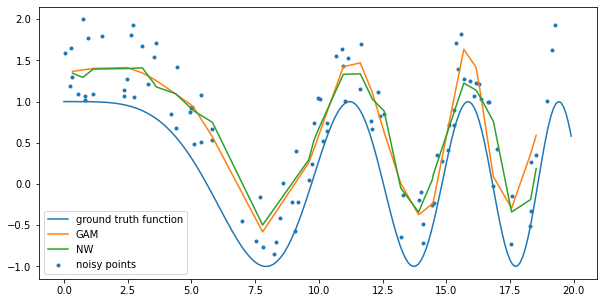

In [59]:
plt.figure(figsize=(10,5))
plt.scatter(x,y_noise,marker='.', label='noisy points')
plt.plot(i,f(i),label="ground truth function")
plt.plot(gam['x'],gam['y'], label='GAM')
plt.plot(x1,y1,label='NW')


plt.legend(loc="lower left")
plt.show()

You will compare the 10-fold crossvalidated root mean square error of the two regressors on the "concrete.csv" data set

In [93]:
data = pd.read_csv('/Users/rebeccawagner/Documents/GitHub/Data 441/Data/concrete.csv')

In [94]:
data.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [109]:
y = data['strength']
x = data[['cement','slag','ash','water','superplastic','coarseagg','fineagg','age']].to_numpy()

In [85]:
from pygam import LinearGAM
from sklearn.model_selection import KFold 

In [124]:
from sklearn.model_selection import KFold 

kf = KFold(n_splits=10)

mse_list = []

for idxtrain, idxtest in kf.split(x):

    xtrain = x[idxtrain]
    ytrain = y[idxtrain]
    ytest = y[idxtest]
    xtest = x[idxtest]

    ss =SS()
    xtrain = ss.fit_transform(xtrain)
    xtest = ss.transform(xtest)

    gam = LinearGAM(n_splines=17).gridsearch(xtrain, ytrain,objective='GCV')

    gam_y_est = gam.predict(xtest)

    mse_list.append(np.sqrt(mse(ytest,gam_y_est)))

    

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% (0 of 11) |                        

In [125]:
np.mean(mse_list)

6.327662705170008

In [120]:
from sklearn.model_selection import KFold 

kf = KFold(n_splits=10)

mse_list = []

for idxtrain, idxtest in kf.split(x):

    xtrain = x[idxtrain]
    ytrain = y[idxtrain]
    ytest = y[idxtest]
    xtest = x[idxtest]

    ss =SS()
    xtrain = ss.fit_transform(xtrain)
    xtest = ss.transform(xtest)
    
    param_grid=[dict(kernel=['polynomial'], degree=np.arange(1, 5)),dict(kernel=['rbf'], gamma=np.logspace(-5, 5, 100))]

    # use the sklearn gridsearch
    nw_gs = GridSearchCV(NadarayaWatson(), cv=10, param_grid=param_grid)
    nw_gs.fit(xtrain,ytrain)
    nw_y_est = nw_gs.predict(xtest)

    mse_list.append(np.sqrt(mse(ytest,nw_y_est)))

In [123]:
np.mean(mse_list)

12.056083657272156